In [7]:
using PyPlot

In [8]:
srand(0);

In [9]:
function block_power_momentum(A,q, max_iters, beta=0)
    n = size(A,1)
    k = size(q,2)
    q_prev = zeros(Float64,n,k)
    Q = [];
    for i in 1:max_iters
        norm_q, _ = qr(q)
        push!(Q, norm_q)
        Aq = A*q;
        qq = Aq - q_prev*beta;
        q_stack, _ = qr([qq;q])
        q = q_stack[1:n,:]
        q_prev = q_stack[n+1:2*n,:]
    end
    return Q
end

function lanczos_iter(A,q,max_iters)
    q = q/norm(q)
    n = size(A,1)
    max_iters = minimum([max_iters, n])
    T = zeros(Float64,max_iters+1, max_iters+1)
    beta0 = 0;
    q0 = zeros(n)
    for i in 1:max_iters
        v = A*q;
        T[i,i] = dot(q,v);
        r = v - beta0*q0 - T[i,i]*q
        beta0 = norm(r)
        T[i,i+1] = beta0
        T[i+1,i] = beta0
        q0 = q;
        q = r/beta0;
    end
    return T
end

function block_power_vm(A, q, max_iters, beta=0)
    n = size(A,1)
    k = size(q,2)
    q_prev = zeros(Float64, n,k)
    Q = [];
    for i in 1:max_iters
        q_norm, _ = qr(q)
        push!(Q, q_norm)

        Aq = A*q
        qq = Aq - q_prev*beta;
        q_stack, _ = qr([qq;q])
        q = q_stack[1:n,:]
        q_prev = q_stack[n+1:2*n,:]
        
    end
    return Q
end

block_power_vm (generic function with 2 methods)

In [10]:
n = 1000;
A = randn(n,n);
U,R = qr(A)
eigvs = collect(Float64,n:-1:1)
eigvs[1:3] = [1.2*n,1.1*n, n]
eigvs = eigvs./n
S = diagm(eigvs)
A = U*S*U';

eigvalues = sort(eigvals(A), rev=true);
lam_max = eigmax(A);
lam_max = eigvs[1];

In [11]:
# eigenvalue estimation trajectory
k = 3
q0 = randn(n,k)
max_iters = 100

# Power iteration
Q_pi = block_power_momentum(A,q0, max_iters, 0)
eigs_pi = [diag(q'*A*q)' for q in Q_pi]

# Power momentum
beta_opt = eigvs[k+1]^2/4
Q_opt = block_power_momentum(A,q0, max_iters, beta_opt)
eigs_pm = [diag(q'*A*q)' for q in Q_opt]

# Lanczos
T = lanczos_iter(A,q0[:,1], max_iters)
eigs_lan = fill(NaN, max_iters,k)
for i in 1:k
    eigs_lan[i,1:i] = sort(eigvals(T[1:i,1:i]), rev=true)
end
eigs_lan[k+1:end,:] = vcat([(sort(eigvals(T[1:i,1:i]), rev=true)[1:k])' for i in k+1:max_iters]...);

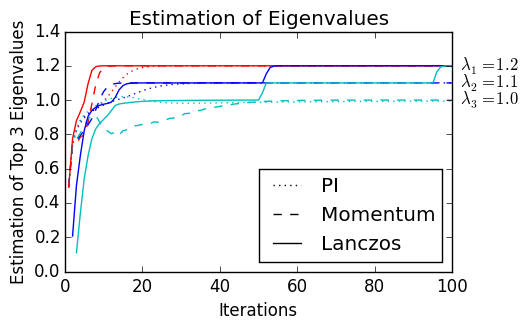

In [12]:
figure(figsize=(5,3))
colors = ["r","b","c"]
plot([NaN], [NaN],"k:")
plot([NaN], [NaN],"k--")
plot([NaN], [NaN],"k-")

eigs_pis = vcat(eigs_pi...)
for i in 1:k
    plot(1:max_iters, eigs_pis[:,i],":", c = colors[i])
end
eigs_pms = vcat(eigs_pm...)
for i in 1:k
    plot(1:max_iters, eigs_pms[:,i],"--", c = colors[i])
end
for i in 1:k
    plot(1:max_iters, eigs_lan[:,i], "-",c = colors[i])
end
xlim([0,max_iters])
xlabel("Iterations");
ylabel(@sprintf("Estimation of Top %d Eigenvalues", k));
annotate(L"\ \ \lambda_1 = 1.2",xy=[100,1.2], va="center")
annotate(L"\ \ \lambda_2 = 1.1",xy=[100,1.1], va="center")
annotate(L"\ \ \lambda_3 = 1.0",xy=[100,1.0], va="center")
legend(("PI","Momentum","Lanczos"),loc="best")

title("Estimation of Eigenvalues")
savefig("Stability.pdf", bbox_inches="tight")